<a href="https://colab.research.google.com/github/AnastasiaAkkuratova/INSIMO/blob/main/laba4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа 4.**

ФИО: Аккуратова Анастасия Александровна

Группа: БИВТ-20-1

Вариант: 1

Датасет: beans

Бобы — это набор изображений бобов, сделанных в поле с помощью камер смартфонов. Он состоит из 3 классов: 2 класса болезней и класса здоровых. Изображенные болезни включают угловую пятнистость листьев и бобовую ржавчину. Данные были аннотированы экспертами из Национального исследовательского института сельскохозяйственных ресурсов (NaCRRI) в Уганде и собраны исследовательской лабораторией искусственного интеллекта Макерере.

Названия классов:

*   Healthy
*   Bean_rust
*   Angular_leaf_spot







1. Импортирую все библиотеки, необдимые для работы

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

2. Использование cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Вы используете {device}")

Вы используете cuda


3. Загрузка датасета и нормализация

In [3]:
# Загрузка датасета "beans"
dataset_name = 'beans'
(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=['train', 'test'], shuffle_files=True, with_info=True, as_supervised=True)

# Нормализация данных
def normalize_img(image, label):
    image = tf.image.resize(image, (200, 200))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

# Создание DataLoader для обучающего и тестового набора данных
batch_size = 32
train_loader = ds_train.batch(batch_size)
test_loader = ds_test.batch(batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteFDTNSS/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteFDTNSS/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteFDTNSS/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


4. Визуализация датасета

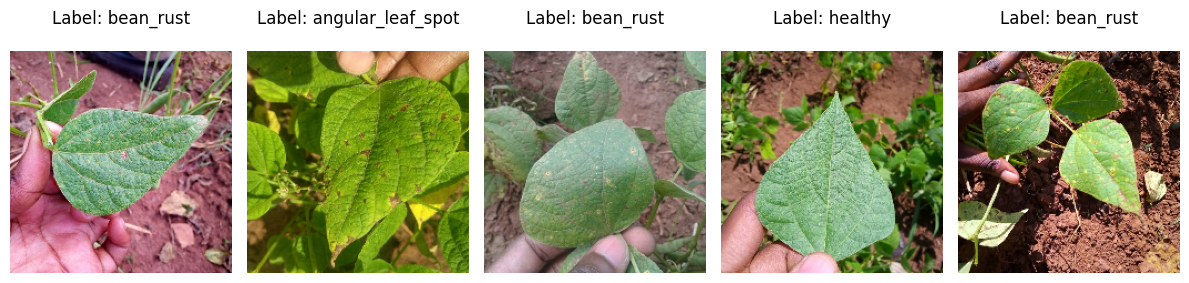

In [4]:
plt.figure(figsize=(12, 10))

for i, (image, label) in enumerate(ds_train.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(f"Label: {ds_info.features['label'].names[label]}", pad=20)
    plt.axis("off")

plt.tight_layout() 
plt.subplots_adjust(top=0.9)
plt.show()


5. Определение количества эпох обучения

In [5]:
epochs = 10

6. Создание, компиляция, обучение и оценка модели на тестовых данных

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Обучение модели
model.fit(train_loader, epochs=epochs)

# Оценка модели на тестовом наборе данных
test_loss, test_acc = model.evaluate(test_loader)
print(f"Точность на тестовой выборке: {test_acc}")

Epoch 1/10
33/33 [==============================] - 15s 103ms/step - loss: 2.0329 - accuracy: 0.3694
Epoch 2/10
33/33 [==============================] - 4s 129ms/step - loss: 0.8008 - accuracy: 0.6451
Epoch 3/10
33/33 [==============================] - 3s 93ms/step - loss: 0.7759 - accuracy: 0.6809
Epoch 4/10
33/33 [==============================] - 3s 91ms/step - loss: 0.4408 - accuracy: 0.8482
Epoch 5/10
33/33 [==============================] - 4s 117ms/step - loss: 0.3716 - accuracy: 0.8685
Epoch 6/10
33/33 [==============================] - 3s 91ms/step - loss: 0.2279 - accuracy: 0.9255
Epoch 7/10
33/33 [==============================] - 3s 92ms/step - loss: 0.1085 - accuracy: 0.9671
Epoch 8/10
33/33 [==============================] - 4s 124ms/step - loss: 0.0880 - accuracy: 0.9720
Epoch 9/10
33/33 [==============================] - 3s 93ms/step - loss: 0.1406 - accuracy: 0.9574
Epoch 10/10
4/4 [==============================] - 1s 91ms/step - loss: 1.5342 - accuracy: 0.5234
Точнос

7. Использование TransferLearning и оценка модели

In [7]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_loader, epochs=epochs)

test_loss, test_acc = model.evaluate(test_loader)
print(f"Точность на тестовой выборке: {test_acc}")


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
33/33 [==============================] - 11s 151ms/step - loss: 12.8799 - accuracy: 0.3491
Epoch 2/10
33/33 [==============================] - 3s 102ms/step - loss: 1.4814 - accuracy: 0.3926
Epoch 3/10
33/33 [==============================] - 3s 102ms/step - loss: 1.1634 - accuracy: 0.4391
Epoch 4/10
33/33 [==============================] - 4s 103ms/step - loss: 1.0467 - accuracy: 0.4652
Epoch 5/10
33/33 [==============================] - 3s 103ms/step - loss: 1.0405 - accuracy: 0.4555
Epoch 6/10
33/33 [==============================] - 5s 137ms/step - loss: 0.9608 - accuracy: 0.5000
Epoch 7/10
33/33 [==============================] - 4s 104ms/step - loss: 0.9533 - accuracy: 0.5087
Epoch 8/10
33/33 [==============================] - 4s 105ms/step - loss: 0.8882 - accuracy: 0.5426
Epoch 9/10
33/33 [==============================] - 5s 139ms/step - loss: 0.8545 - accuracy: 0.5445
Epoch 10/10
4/4 [================